# Lesson 2: Light Curves, Quality Flags, and Exoplanets

## Learning Goals: 
- Filter TESS lightcurve data based on quality flags and their meaning.
- Search the MAST archive by target name, download and view a lightcurve .fits file, only as an initial data check.
- Utilize the Lightkurve package to:
   * download and view a lightcurve
   * create a periodogram to find the maximum period
   * view a folded and normalized light curve
- Understand the potential consequences for ignoring quality flags.

<!-- - Apply data quality flags to remove less than ideal data and re-plot the lightcurve. -->

## Lesson Outline:
- Query and Download TESS data from MAST to check for observations of our system.
- Use the Lightkurve package to download TESS data, create a periodogram to find the maximum period, then phase fold and plot. 
- Remove data corresponding to data quality flags, and re-plot, to confirm or refute the detection of a planet. 
<!-- - Generate a lightcurve, then phase fold to look for a planetary transit. 
- Reassess the result using quality flags: should we really be using everything? Which flags are going to be problematic for our analysis?
- Appropriately filter the data to return a valid light curve, now without a planet.
 -->

## Imports
The following cell holds the imported packages. These packages are necessary for running the rest of the cells in this notebook, and you can expect to use some of these packages almost everytime you do astronomical research. A description of each import is as follows:

* `numpy` to handle array mathematics
* `pandas` to handle date conversions
* `fits` from astropy.io for accessing FITS files
* `lightkurve` for advanced processing of our light curves
* `Table` from astropy.table for creating tidy tables of the data
* `WCS` from astropy.wcs for storing World Coordinate Systems information 
* `SkyCoord` from astropy.coordinates for defining RA and Dec for targets
* `matplotlib.pyplot` for plotting data and images
* `Mast` and `Observations` from astroquery.mast for querying data and observations from the MAST archive

In [ ]:
pip install --force-reinstall astropy==5.2.2

In [ ]:
pip install --force-reinstall numpy==1.24.4

In [1]:
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astroquery.mast import Mast, Observations
from astropy.io import ascii
from astropy.time import Time
import requests
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


### Choosing a Target

We will be exploring the exoplanetary system around the star HD 21749. In 2019, TESS observations lead to the discovery of 2 exoplanets around HD 21749, one of which is Earth sized. HD 21749 is a K-type main sequence star, it has an estimated mass of 0.73 $M_☉$, a radius of 0.70 $R_☉$, and a luminosity of 0.20 $L_☉$.

The inner planet, HD 21749 c, is orbiting at a distance of 0.08 AU with a period of just 7.8 days. It has a radius of 1.1 R🜨 and was the first Earth-sized planet found by TESS. The outer planet, HD 21749 b, orbits the star at a distance of 0.21 AU with a period of 35.6 days. 

These planets have been confirmed, but the orbit very close to their star, so let's see if we can actually find their transits in the TESS lightcurves, while making sure to practice good data hygiene. You can find more information about HD 21749 b and c at [NASA's Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/overview/HD%2021749#planet_HD-21749-c_collapsible), 

Note: The NASA Exoplanet Archive uses a different name for this star, "GJ 143" is the same star as HD 21749. For more information about star catalogs and naming conventions, check out this page from the [International Astronomical Union](https://www.iau.org/public/themes/naming_stars/).

<!-- We can examine all the exoplanets examined by TESS on the Target Of Interest [(TOI) Catalog](https://tev.mit.edu/data/collection/193/).

The data we will be exploring today is of the star **TOI-1380**. TESS observed this star during Sectors 15 & 16, let's analyze a TESS lightcurve to try to figure out if there is a planet orbiting this star.  -->

### Query and Download TESS data

In [2]:
obs_table = Observations.query_criteria(objectname="HD 21749", obs_collection = 'TESS', radius = "1s")

#take a look at the results of our query
obs_table.show_in_notebook()

idx,intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
0,science,TESS,SPOC,Photometer,TESS,TESS,Optical,279741379,--,tess2020238165205-s0029-0000000279741379-0193-s,51.746761965648,-63.4991005063024,timeseries,"Ricker, George",3,59087.739871,59113.9343709,120.0,600.0,1000.0,--,59158.0,G03188_G03278_G03126_G03227_G03106,--,29,CIRCLE ICRS 51.74676197 -63.49910051 0.00138889,--,mast:TESS/product/tess2020238165205-s0029-0000000279741379-0193-s_lc.fits,PUBLIC,False,nan,27897122,71371815,71371815,0.0
1,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0002-3-4,50.281959503030045,-59.52220377244678,image,"Ricker, George",3,58353.60551208333,58381.001615243054,1425.599438,600.0,1000.0,--,58458.5833333,N/A,--,2,POLYGON 59.465294 -66.970971 33.777971 -62.198834 44.953858 -51.565965 63.253468 -55.299199 59.465294 -66.970971,--,--,PUBLIC,False,nan,60902968,112738708,112738708,0.0
2,science,TESS,SPOC,Photometer,TESS,TESS,Optical,279741379,--,tess2018206190142-s0001-s0036-0000000279741379,51.746761965648,-63.4991005063024,timeseries,"Ricker, George",3,58324.79387945602,59253.56332516204,120.0,600.0,1000.0,--,59389.0,N/A,--,36,CIRCLE 51.74676197 -63.49910051 0.00138889,--,mast:TESS/product/tess2018206190142-s0001-s0036-0000000279741379-00471_dvt.fits,PUBLIC,False,nan,61531964,116663066,116663066,0.0
3,science,TESS,SPOC,Photometer,TESS,TESS,Optical,279741379,--,tess2020238165205-s0029-0000000279741379-0193-a_fast,51.746761965648,-63.4991005063024,timeseries,"Ricker, George",3,59087.739871,59113.93529683,20.0,600.0,1000.0,--,59158.0,G03188_G03278_G03126_G03227_G03106,--,29,CIRCLE ICRS 51.74676197 -63.49910051 0.00138889,--,mast:TESS/product/tess2020238165205-s0029-0000000279741379-0193-a_fast-lc.fits,PUBLIC,False,nan,27973866,71525282,71525282,0.0
4,science,TESS,SPOC,Photometer,TESS,TESS,Optical,279741379,--,tess2020266004630-s0030-0000000279741379-0195-a_fast,51.746761965648,-63.4991005063024,timeseries,"Ricker, George",3,59115.38575671,59142.72319078,20.0,600.0,1000.0,--,59173.0,G03188_G03278_G03126_G03227_G03106,--,30,CIRCLE ICRS 51.74676197 -63.49910051 0.00138889,--,mast:TESS/product/tess2020266004630-s0030-0000000279741379-0195-a_fast-lc.fits,PUBLIC,False,nan,27987479,71552508,71552508,0.0
5,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0030-3-3,47.34301740355341,-61.6317015269356,image,"Ricker, George",3,59115.38322442,59142.72317936,475.199788,600.0,1000.0,--,59173.0,N/A,--,30,POLYGON 44.48218800 -69.69178600 30.27270200 -59.86156700 49.05198400 -53.23774300 65.21929000 -61.41712300 44.48218800 -69.69178600,--,--,PUBLIC,False,nan,28055408,71688351,71688351,0.0
6,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0034-4-3,68.34092172890475,-66.20876789929525,image,"Ricker, George",3,59228.248929,59253.56113544,475.19979,600.0,1000.0,--,59281.0,N/A,--,34,POLYGON 50.47599200 -63.26598500 71.17225600 -57.81363500 89.52411900 -66.67195800 61.63086600 -74.40958100 50.47599200 -63.26598500,--,--,PUBLIC,False,nan,28364164,72305766,72305766,0.0
7,science,TESS,SPOC,Photometer,TESS,TESS,Optical,279741379,--,tess2018263035959-s0003-0000000279741379-0123-s,51.746761965648,-63.4991005063024,timeseries,"Ricker, George",3,58381.53470193287,58408.88306165509,120.0,600.0,1000.0,--,58507.6666666,G011025,--,3,CIRCLE 51.74676197 -63.49910051 0.00138889,--,mast:TESS/product/tess2018263035959-s0003-0000000279741379-0123-s_lc.fits,PUBLIC,False,nan,60914649,121725731,121725731,0.0
8,science,TESS,SPOC,Photometer,TESS,TESS,Optical,279741379,--,tess2020212050318-s0028-0000000279741379-0190-s,51.746761965648,-63.4991005063024,timeseries,"Ricker, George",3,59061.35062287,59086.59819154,120.0,600.0,1000.0,--,59

When checking for observations of the system you are interested in, it is important to do a quick search like this and make sure there are enough data aligned with your research goal. From this table we know TESS has two FFIs and two timeseries files. Reminder: there are two types of timeseries files that TESS hosts, Target Pixel Files and Light Curve files. 

A Target Pixel file (TPF) is a "postage stamp": a tiny subsection of TESS's full field of view that is focused around a specific target. TPFs are essentially a collection of images, allowing us to precisely measure the brightness of a particular patch of the sky.

A Light Curve (LC) is a more processed version of a TPF, with target brightness already extracted. This makes it easy to create a plot, but we lose the ability to select which pixels belong to the target, and which pixels to the background.

For more information on the different data products from TESS, head over to this page of the [TESS Archive Documentation Center](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview). 

So, we now know there are optical timeseries files of HD 21749 taken by TESS, so we can move forward. 

### Get Data Products

Now it is time to actually get the data products that we would like to analyse. For our purposes, we will be looking for "LC" files, LC stands for Light Curve and these files are pre-made light curves processed by the TESS pipeline. You can find more information about the different file types from TESS in the [TESS Data Archive Manual](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview). 

In [3]:
#get all data products corresponding to the TESS observations we queried
data_products = Observations.get_product_list(obs_table)

#filter data products to just retrieve science light curves from TESS
lc_data_products = Observations.filter_products(data_products,productSubGroupDescription="LC",productType = "SCIENCE",productGroupDescription = "Minimum Recommended Products")
lc_data_products.show_in_notebook()

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
0,60842699,TESS,timeseries,tess2018206045859-s0001-0000000279741379-0120-s,Light curves,S,mast:TESS/product/tess2018206045859-s0001-0000000279741379-0120-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,b11c787608,G011025,tess2018206045859-s0001-0000000279741379-0120-s_lc.fits,2039040,60842699,PUBLIC,3
1,60868489,TESS,timeseries,tess2018234235059-s0002-0000000279741379-0121-s,Light curves,S,mast:TESS/product/tess2018234235059-s0002-0000000279741379-0121-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.11-20200915,G011025,tess2018234235059-s0002-0000000279741379-0121-s_lc.fits,2004480,60868489,PUBLIC,3
2,60914649,TESS,timeseries,tess2018263035959-s0003-0000000279741379-0123-s,Light curves,S,mast:TESS/product/tess2018263035959-s0003-0000000279741379-0123-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,5c21567b49,G011025,tess2018263035959-s0003-0000000279741379-0123-s_lc.fits,1998720,60914649,PUBLIC,3
3,61105845,TESS,timeseries,tess2018292075959-s0004-0000000279741379-0124-s,Light curves,S,mast:TESS/product/tess2018292075959-s0004-0000000279741379-0124-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,60126d3480,G011025,tess2018292075959-s0004-0000000279741379-0124-s_lc.fits,1897920,61105845,PUBLIC,3
4,27821201,TESS,timeseries,tess2020212050318-s0028-0000000279741379-0190-s,Light curves,S,mast:TESS/product/tess2020212050318-s0028-0000000279741379-0190-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.9-20200827,G03188_G03278_G03126_G03227_G03106,tess2020212050318-s0028-0000000279741379-0190-s_lc.fits,1848960,27821201,PUBLIC,3
5,27897122,TESS,timeseries,tess2020238165205-s0029-0000000279741379-0193-s,Light curves,S,mast:TESS/product/tess2020238165205-s0029-0000000279741379-0193-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.13-20201001,G03188_G03278_G03126_G03227_G03106,tess2020238165205-s0029-0000000279741379-0193-s_lc.fits,1915200,27897122,PUBLIC,3
6,27985127,TESS,timeseries,tess2020266004630-s0030-0000000279741379-0195-s,Light curves,S,mast:TESS/product/tess2020266004630-s0030-0000000279741379-0195-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.16-20201026,G03188_G03278_G03126_G03227_G03106,tess2020266004630-s0030-0000000279741379-0195-s_lc.fits,1998720,27985127,PUBLIC,3
7,28308292,TESS,timeseries,tess2021014023720-s0034-0000000279741379-0204-s,Light curves,S,mast:TESS/product/tess2021014023720-s0034-0000000279741379-0204-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.23-20210212,G03188_G03278_G03126_G03227_G03106,tess2021014023720-s0034-0000000279741379-0204-s_lc.fits,1854720,28308292,PUBLIC,3
8,117956912,TESS,timeseries,tess2023018032328-s0061-0000000279741379-0250-s,Light curves,S,mast:TESS/product/tess2023018032328-s0061-0000000279741379-0250-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.81-20230208,G05002_G05144,tess2023018032328-s0061-0000000279741379-0250-s_lc.fits,1860480,117956912,PUBLIC,3
9,139096958,TESS,timeseries,tess2023096110322-s0064-0000000279741379-0257-s,Light curves,S,mast:TESS/product/tess2023096110322-s0064-0000000279741379-0257-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.86-20230328,G05002_G05144,tess2023096110322-s0064-0000000279741379-0257-s_lc.fits,1969920,139096958,PUBLIC,3


### Downloading FITS file

File Image Transport System (FITS) is a file format designed to store, transmit, and manipulate scientific images and associated data. It is the most widely used file type in astronomical research. A FITS file consists of one or more Header + Data Units (HDUs), where the first HDU is called the primary HDU, or primary array. The primary array may be empty or contain an N-dimensional array of pixels, such as a 1-D spectrum, a 2-D image, or a 3-D data cube. 

For more info on FITS files, here is a link to the FITS official [website](https://fits.gsfc.nasa.gov/). 

Next we will be downloading the FITS file corresponding to the light curve we want to analyse, let's take a look at what is inside the file. 

In [4]:
data = Observations.download_products(lc_data_products)["Local Path"][0]
#Take a peek at the FITS file we downloaded
fits_file = data

fits.info(fits_file)
fits_lc = fits.open(fits_file)

lc = fits_lc[1].data
lc.columns

Filename: ./mastDownload/TESS/tess2018206045859-s0001-0000000279741379-0120-s/tess2018206045859-s0001-0000000279741379-0120-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   20076R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 13)   int32   


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

We can see that there are three extensions to this FITS file: PRIMARY, LIGHTCURVE, AND APERTURE. We will be interested in the LIGHTCURVE extension, so we have selected that extension and called it "lc". After printing out the data columns in lc, we see that there are columns for time and flux, which we will use to plot the data. 

Additionally, we can notice that there are different types of fluxes in this FITS file. SAP and PDCSAP. 

The Simple Aperture Photometry (SAP) is the summation of all the pixel values in a pre-defined aperture as a function of time.

The Pre-search Data Conditioning SAP flux (PDCSAP) flux is the SAP flux from which long term trends have been removed using so-called Co-trending Basis Vectors (CBVs). PDCSAP flux is usually cleaner data than the SAP flux and will have fewer systematic trends. 

For more information on the levels of data processing by TESS, head over to this page of the [TESS Archive Documentation Center](https://outerspace.stsci.edu/display/TESS/2.1+Levels+of+data+processing). 

Now we can check to see what this light curve looks like. 

#### Plot raw light curves from data as a check

Text(0.5, 0, 'BJD-2457000')

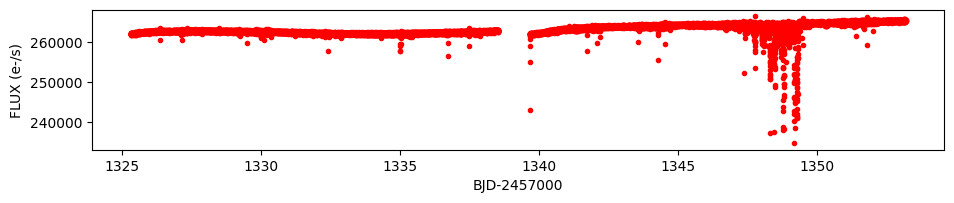

In [5]:
flux = lc['SAP_FLUX'] #SAP flux column
flux_err = lc['SAP_FLUX_ERR'] #SAP flux error
time_lc = lc['TIME'] #time column
quality = lc['QUALITY'] #quality flags column

fig = plt.figure(figsize = (11,4))
fig.add_subplot(211)
plt.plot(time_lc, flux,'.', color = "red")
plt.ylabel("FLUX (e-/s)")
plt.xlabel("BJD-2457000")

So far, we have accomplished two things: 
 1. confirmed that MAST indeed has TESS observations of our target.
 2. plotted a light curve of our target as an initial check. 
     
Do you see any potential transits? Let's continue to analyze this data to confirm or deny them!

### The LightKurve package
The LightKurve package is an open source python library of functions that make analysing light curves straightforward. From the [LightKurve documentation](https://docs.lightkurve.org/): "Lightkurve offers a user-friendly way to analyze time series data on the brightness of planets, stars, and galaxies. The package is focused on supporting science with NASA’s Kepler and TESS space telescopes, but can equally be used to analyze light curves obtained by your backyard telescope."

### Normalizing Flux

"Normalizing" changes the flux from being in units of raw electrons per second to being a fraction of the median flux value. This makes visualizing the flux much easier by displaying the total flux as a value out of 1, without changing anything about the data physically. We will be using the LightKurve package to normalize our data. 

### Phase Folding

"Phase folding" is the act of summing up the amount of flux within a certain period that corresponds to the period variation of the flux. This will make it so that our light curve is plotted as function of orbital phase instead of time. Since we know there is a planet around this star, the period we are looking for is the orbital period of the planet. In order to find the period we want to fold the data into, we will need to create a periodogram. A periodogram is a way to visualize oscillating data in the frequency domain rather than the time domain, this change of domain is done through a Fourier transform, which is illustrated by the gif below. There is a lot more information on this in the tutorial notebook [Creating Periodograms](https://spacetelescope.github.io/mast_notebooks/notebooks/Kepler/creating_periodograms/creating_periodograms.html?highlight=periodogram). We will use the LightKurve package to create the periodogram, use the periodogram to find the maximum period, and then perform the phase folding using that period. 

<img src="https://upload.wikimedia.org/wikipedia/commons/5/50/Fourier_transform_time_and_frequency_domains.gif" width = 500>

This gif was created by Lucas Vieira and you can find it on [WikimediaCommons](https://commons.wikimedia.org/wiki/File:Continuous_Fourier_transform_of_rect_and_sinc_functions.gif).

For a good visual introduction to Fourier transforms, [this video by 3Blue1Brown](https://www.youtube.com/watch?v=spUNpyF58BY) on YouTube is a great place to start. 

Now we are going to perform the phase folding, but first we have to get the target pixel file data corresponding to one of our observations. Above, under the subheading **Get Data Products**, we queried the observations from TESS of HD 21749. We can use the table we printed out there, in the column **obs_id**, to get just one of those observations, so we don't have to retrieve the same data again. In this next cell, we just use one of the obs_id from that table above and use it to query the target pixel file for that observation. 

In [6]:
ex_id = "tess2018206045859-s0001-0000000279741379-0120-s"

#Query MAST for this TESS observation
TESS_table = Observations.query_criteria(obs_id=ex_id) 


# Get associated science products for each Observation
data_products = Observations.get_product_list(TESS_table)

#This time we want to retrieve a target pixel file (TP) instead of a light curve (LC)
tp_prod = Observations.filter_products(data_products
                                       , obs_id = ex_id    # Using the same example as above
                                       , productSubGroupDescription = "TP")

#Download FITS file
tp_path = Observations.download_products(tp_prod)["Local Path"][0]

INFO: Found cached file ./mastDownload/TESS/tess2018206045859-s0001-0000000279741379-0120-s/tess2018206045859-s0001-0000000279741379-0120-s_tp.fits with expected size 58017600. [astroquery.mast.cloud]


Now, we will generate a light curve from the target pixel file we downloaded using the Lightkurve package 

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

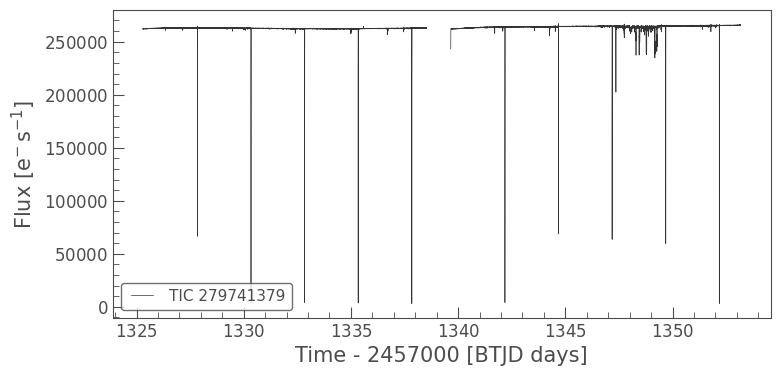

In [7]:
tp = lk.read(tp_path, quality_bitmask="none", flux_column="sap_flux")
lc = tp.to_lightcurve()
lc.plot()

We can see from this plot that there is a gap between the two cadences, let's limit our periodogram to just the time values before that gap. 

<Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{\\frac{e^{-}}{s}}$]'>

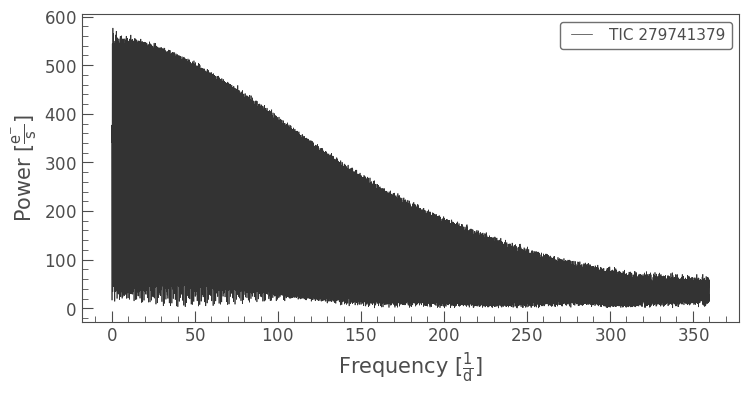

In [8]:
#create the periodogram
pg = lc[lc['time'].value < 1339].to_periodogram() 
pg.plot()

Woah! There is so much signal here it's impossible to tell what period we are looking for. Let's limit our periods to a smaller range. 

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{\\frac{e^{-}}{s}}$]'>

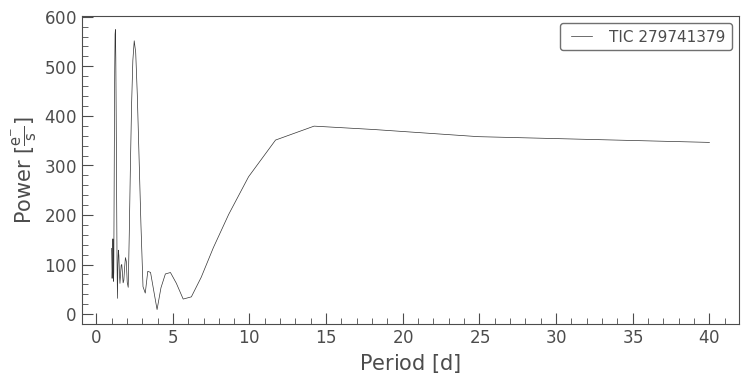

In [9]:
pg = lc[lc['time'].value < 1339].to_periodogram(minimum_period = 1, maximum_period = 40)
pg.plot()

<!-- # pg = lc[lc['time'].value < 1339].to_periodogram(minimum_period=0.5, maximum_period=3) -->

Great ! The maximum period is much more visible now. The next step is to phase fold the flux corresponding to the orbital period of our potential exoplanet, this will be the maximum period we see in the periodogram. 

In [10]:
#get the orbital period of our planet
period = pg.period_at_max_power
print(period)

#phase fold the light curve and normalize the flux
folded_lc = lc.fold(period)
folded_norm_lc = folded_lc.normalize()

1.256011077112194 d


Text(0.5, 0, 'ORBITAL PHASE')

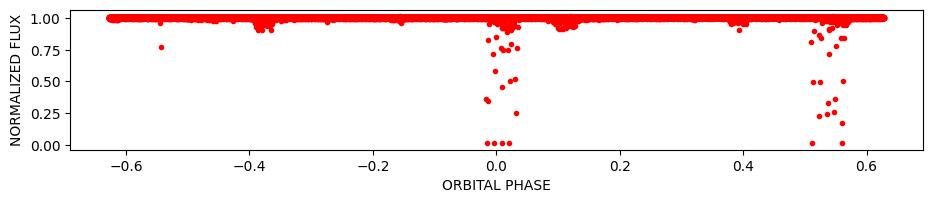

In [11]:
phase = folded_norm_lc['time'].value
flux = folded_norm_lc['flux']
quality = folded_norm_lc['quality']

#plot the normalized and phase folded light curve
fig = plt.figure(figsize = (11,4))
fig.add_subplot(211)
plt.plot(phase, flux,'.', color = "red")
plt.ylabel("NORMALIZED FLUX")
plt.xlabel('ORBITAL PHASE')

At first glance, it might seem like we have a couple decent dips in our light curve, near phases 0.0 and 0.6, indicating the transits of our exoplanets. But, remember that a transiting planet will not reduce a star's light to 0.0 flux, that would mean that the planet's radius is the same or larger than its parent star, so it is suspicious that our potential transits appear to be doing that. Really, all the values for our dips are concerningly small. Additionally, a real transit would have a clear "down" and then "up" shape to them, but these appear to be randomly distributed. 

Therefore, it is clear we will need to take into account the data quality flags for this observation and reevaluate our light curve. Once we clean up the data, this will provide us with a more accurate light curve and allow us to confirm or reject a transit detection. 


<!-- 
In our last lesson, we learned how to plot a light curve in order to search for exoplanets through the transit method. You may have noticed that some of our light curves were noisy or had a "messy" signal, in this lesson we will be learning how to improve the quality of our data and produce better light curves. The process to do this utilizes data quality flags.  -->

## What are data quality flags?

Data quality flags are an indicator in the data that tell the user whether or not the data has been corrected or is deemed poor quality. These flags are put in by the TESS team after making a statistical assessment of the data. We can use these quality flags to throw out bad data and clean up our light curves in order to get a less noisy signal and give us a better chance of finding an exoplanet transit. 

**The STScI website provides the following advice on TESS quality flags:**

"Not all of these pixels indicate that the data quality is bad. In many cases the flags simply indicate that a correction was made. For instance, bit 7 indicates that a cosmic ray was corrected on one of the pixels in the optimal aperture. If this is the only flag on this cadence, then the data is likely fine and should not be excluded from your analysis. Different science cases may warrant different usages of these flags. As a starting point, the following flags indicate that the cadence will likely be of lesser quality: 1,2,3,4,5,6,8,10,13, and 15. More specifically, a bit-wise AND with the binary number 0101001010111111 indicate cadences that are likely of lesser quality." For more information, check out the [TESS Archive Manual](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview) . 

### What if we ignore quality flags?
We saw from Lesson 1 that if we plot the data without taking into account any data quality flags, we see very messy signal in certain parts of the light curve. This noise can drown out a possibly faint planetary transit if the "dip" in the light curve from the transit is smaller than the variation of the bad data. Coversely, if we don't remove bad data, we run the risk of misidentifying a noisy signal as a transit.



### Clean up the data
By looking at the columns of the light curve data, we can see there are quality flags for anomolies in the data that we can now remove in order to get the best light curve possible. 

There are several quality flags in place, and you can learn about all of them in the [Archive Manual](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview). For now, we will just be removing data that corresponds to the following flags:

- Bit 1. Attitude Tweak
- Bit 2. Safe Mode
- Bit 3. Coarse Point
- Bit 4. Earth Point
- Bit 5. Argabrightening Event (Sudden brightening across the CCD.)
- Bit 6. Reaction Wheel Desaturation
- Bit 8. Manual Exclude
- Bit 10. Impulsive outlier
- Bit 12. Straylight detected
- Bit 13. Scattered light
- Bit 15. Bad Calibration

In [12]:
bad_bits = np.array([1,2,3,4,5,6,8,10,12,13,15])
value = 0
for v in bad_bits:
    value = value + 2**(v-1)
    
bad_data = np.bitwise_and(quality, value) >= 1 
print(bad_data)

[False False False ... False False False]


In this bad_data array, TRUE means that the data at this index is flagged (bad), and FALSE means that the data at this index is not flagged (good). So, when we want to plot everything except the bad data, we will take our array and parse it on $\sim$bad_data. The tilde sign ($\sim$) is used when we work with Boolean values, it works as a negation operator that means it is used to reverse the Boolean values, so the command ```~boolean_array``` returns only the TRUE values in that array.

### Re-plot the light curve after removing bad data

Text(0.5, 0, 'ORBITAL PHASE')

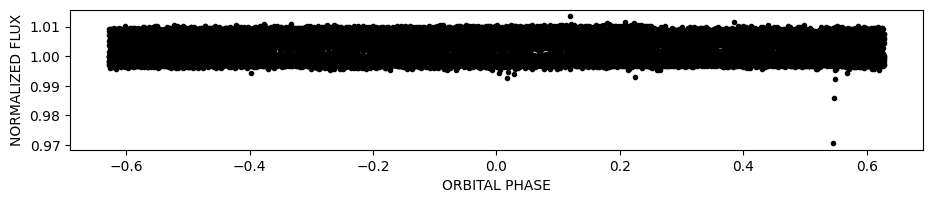

In [13]:
fig = plt.figure(figsize = (11,4))

fig.add_subplot(212)
plt.plot(phase[~bad_data], flux[~bad_data],'.', color = "black") 
plt.ylabel("NORMALIZED FLUX")
plt.xlabel('ORBITAL PHASE')

### Over-plot the original light curve with the cleaned light curve to compare

Text(0.5, 0, 'PHASE')

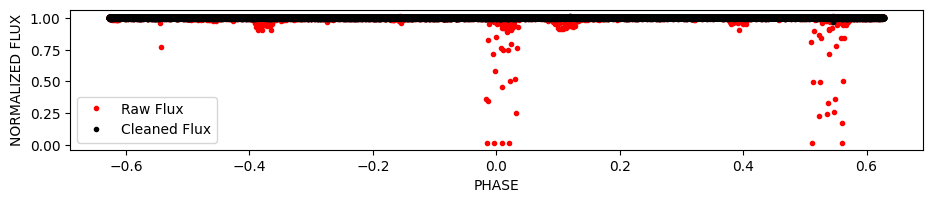

In [14]:
fig = plt.figure(figsize = (11,4))
fig.add_subplot(211)
plt.plot(phase, flux,'.', label = 'Raw Flux', color = "red")
plt.plot(phase[~bad_data], flux[~bad_data],'.', label = 'Cleaned Flux', color = "black")
plt.legend()
plt.ylabel("NORMALIZED FLUX")
plt.xlabel('PHASE')

Immediately we can see that what we may have concluded were transits of our exoplanets in our original light curve were actually just bad quality data which got removed when we cleaned up the original light curve. 

This is a prime example of how important it is to always account for the quality flags of our data when trying to draw conclusions from a visual analysis. 

## Homework

Let's look at how data quality flags affect TESS observations of TRAPPIST-1. This will require you to go back and recall how to query TESS observations of TRAPPIST-1 and retrieve a light curve fits file (HINT: go back to Lesson 1). Now,

(a) Write a Python code snippet that returns the count of observations for each quality flag bit value (0 to 15).

(b) Implement a Python code snippet that calculates the percentage of observations with quality flag bit values of 12 and 13.

(c) Write a Python code snippet that filters the dataset to exclude observations with quality flag bit values of 12 and 13.

## Additional Resources

Head over to the TESS Archive Documentation Center for pages on [Data Products](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview) and [Levels of Data Processing](https://outerspace.stsci.edu/display/TESS/2.1+Levels+of+data+processing) form TESS. 
The Data Product Overview page also has information about TESS data quality flags page all about data quality flags. 

Here is the [SIMBAD page](https://simbad.u-strasbg.fr/simbad/sim-id?Ident=HD+21749&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) on HD 21749. 

The [Lightkurve package website](https://docs.lightkurve.org/) has a lot of documentation on the different functions available, including their page on how the default [to_periodogram()](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.LombScarglePeriodogram.from_lightcurve.html#lightkurve.periodogram.LombScarglePeriodogram.from_lightcurve) function works. 

## Acknowledgements

This notebook includes data collected with the TESS mission, obtained from the MAST data archive at the Space Telescope Science Institute (STScI). Funding for the TESS mission is provided by the NASA Explorer Program. STScI is operated by the Association of Universities for Research in Astronomy, Inc., under NASA contract NAS 5–26555.

Any published work that uses Astroquery should include a citation which can be found at [this link](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION) or the BibTeX entry is available from the package itself with: `astroquery.__citation__`

### Notebook Information:
Author: Emma Lieb

Last Updated: 08/29/2023